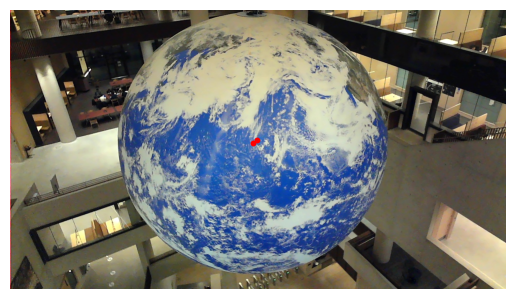

In [3]:
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from collections import deque
import cv2
import os



def threshoding(hsv_image: Image.Image, hue_threshold: list, saturation_threshold: int = 0) -> np.ndarray:
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)

    hue_channel = hsv_array[:, :, 0]
    saturation_channel = hsv_array[:, :, 1]
    mask = (hue_channel >= hue_threshold[0]) & (hue_channel <= hue_threshold[1]) & (saturation_channel >= saturation_threshold)
    binary_image = np.zeros_like(hue_channel)
    binary_image[mask] = 255

    return binary_image


def region_growing(hsv_image: Image.Image, seed_point: tuple, threshold: int):
    # Setup
    hsv_image_copy = hsv_image.copy()
    hsv_array = np.array(hsv_image_copy)
    hue_channel = hsv_array[:, :, 0]

    if threshold == 0:
        return np.zeros_like(hue_channel)

    seeds = seed_point # Your ocean seed
    connectivity = 4 # or 8
    flags = connectivity | (255 << 8) | cv2.FLOODFILL_FIXED_RANGE
    
    # floodFill expects a numpy array. 
    # We work on the Hue channel directly.
    # Note: cv2.floodFill modifies the image in-place, so we copy.
    work_image = hue_channel.copy()
    
    h, w = work_image.shape
    mask = np.zeros((h+2, w+2), np.uint8) # floodFill requires mask to be 2px larger
    
    # Run Region Growing (Instant in C++)
    # For 1-channel image, newVal is a scalar, loDiff/upDiff are scalars.
    cv2.floodFill(work_image, mask, seeds, 255, (threshold,), (threshold,), flags)
    
    # Extract the actual binary map (Crop the 2px border)
    binary_output = mask[1:-1, 1:-1]

    return binary_output

def threshold_and_region_growing(hsv_image: Image.Image, rg_threshold: int, saturation_threshold: int = 120):
    binary_seeds = threshoding(hsv_image, hue_threshold=[140, 190], saturation_threshold=saturation_threshold)



    segmented_images = []
    for y in range(0, binary_seeds.shape[0], 50):
        for x in range(0, binary_seeds.shape[1], 50):
            if binary_seeds[y, x] == 255:
                # print(f"Seed found at: ({x}, {y})")
                segmented_image = region_growing(hsv_image, seed_point=(x, y), threshold=rg_threshold)
                segmented_images.append(segmented_image)
    # Combine all segmented images
    combined_segmented_image = np.zeros_like(binary_seeds)
    for seg_img in segmented_images:
        combined_segmented_image = np.maximum(combined_segmented_image, seg_img)
    # plt.imshow(combined_segmented_image, cmap='gray')
    # plt.axis('off')
    # plt.show()

    return combined_segmented_image


def get_circle_from_3_points(p1, p2, p3):
    """
    Mathematical helper to find (cx, cy, r) from 3 points.
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    
    D = 2 * (x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
    
    if abs(D) < 1e-7: # Points are collinear (straight line)
        return None
        
    center_x = ((x1**2 + y1**2) * (y2 - y3) + (x2**2 + y2**2) * (y3 - y1) + (x3**2 + y3**2) * (y1 - y2)) / D
    center_y = ((x1**2 + y1**2) * (x3 - x2) + (x2**2 + y2**2) * (x1 - x3) + (x3**2 + y3**2) * (x2 - x1)) / D
    
    radius = np.sqrt((center_x - x1)**2 + (center_y - y1)**2)
    
    return (center_x, center_y, radius)

def fit_circle_ransac(img, max_iterations=2000, distance_threshold=2.0):
    """
    Fits a circle to the edge points of an image using RANSAC.
    
    img: Input image (RGB or BGR or Gray)
    """
    # Convert PIL to Numpy if needed
    if isinstance(img, Image.Image):
        img = np.array(img)
        # PIL is RGB, OpenCV expects BGR usually.
        # We will convert to Gray anyway.
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif isinstance(img, np.ndarray):
        if len(img.shape) == 3:
            # Assume BGR if numpy array (standard OpenCV)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            gray = img
    else:
        return None, None

    # Edge detection to find points
    edges = cv2.Canny(gray, 100, 200)
    
    # Get coordinates of edge points
    # np.where returns (row, col) -> (y, x)
    y_coords, x_coords = np.where(edges > 0)
    points = np.column_stack((x_coords, y_coords))
    
    if len(points) < 3:
        print("Not enough points for RANSAC")
        return np.zeros_like(gray), (0, 0, 0, 0)

    best_circle = None
    max_inliers = 0
    
    # RANSAC Loop
    for i in range(max_iterations):
        # A. Pick 3 random points
        sample_indices = np.random.choice(len(points), 3, replace=False)
        p1, p2, p3 = points[sample_indices]
        
        # B. Calculate Circle from 3 points
        temp_circle = get_circle_from_3_points(p1, p2, p3)
        
        if temp_circle is None: continue 
        
        cx, cy, r = temp_circle
        
        # Filter circles that are too small or too large
        if r > max(gray.shape) or r < 50: 
            continue
            
        # Check if center is somewhat within image bounds
        if not (-r < cx < gray.shape[1] + r and -r < cy < gray.shape[0] + r):
            continue

        # C. Calculate distances of ALL points to this circle center
        dists = np.sqrt((points[:, 0] - cx)**2 + (points[:, 1] - cy)**2)
        
        # D. Count Inliers
        error = np.abs(dists - r)
        inliers_count = np.count_nonzero(error < distance_threshold)
        
        # E. Keep the best model
        if inliers_count > max_inliers:
            max_inliers = inliers_count
            best_circle = (cx, cy, r)
            
    # Create mask and bbox
    mask = np.zeros_like(gray)
    bbox = (0, 0, gray.shape[1], gray.shape[0])
    
    if best_circle:
        cx, cy, r = best_circle
        cv2.circle(mask, (int(cx), int(cy)), int(r), 255, -1)
        
        x1 = int(max(cx - r, 0))
        y1 = int(max(cy - r, 0))
        x2 = int(min(cx + r, gray.shape[1]))
        y2 = int(min(cy + r, gray.shape[0]))
        bbox = (x1, y1, x2, y2)
        
    return mask, bbox


def main():
    image_dir = "./Dataset_25/task_2"
    
    centres = []
    for file in os.listdir(image_dir):
        if file.endswith(".jpg"):
            image_path = os.path.join(image_dir, file)
            image = Image.open(image_path).convert('RGB')

            segmented_image = threshold_and_region_growing(image, rg_threshold=30, saturation_threshold=120)
            ransac_mask, box = fit_circle_ransac(segmented_image)
            centre = np.average(np.column_stack(np.where(ransac_mask > 0)), axis=0)[::-1]  # (x, y)


            centres.append(centre)
    
    ref_img_path = os.path.join(image_dir, "calibration_image_00_cam1.jpg")
    # plot the centres on the reference image
    ref_image = Image.open(ref_img_path).convert('RGB')
    plt.imshow(ref_image)
    for centre in centres:
        if centre is not None:
            plt.scatter([centre[0]], [centre[1]], color='red', s=10)
    plt.axis('off')
    plt.savefig('centre_swing.png', bbox_inches='tight', pad_inches=0.1)
    plt.show()



if __name__ == '__main__':
    main()